In [46]:
import numpy as np
from zipline import run_algorithm
from zipline.api import order_target_percent, symbol, schedule_function, date_rules, time_rules, record,order
from datetime import datetime
import pytz
import pyfolio as pf
import pandas as pd
import matplotlib.pyplot as plt
import talib

def initialize(context):
    # Which stocks to trade
    
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    tables = pd.read_html(url)
    now_sp500_ticker = list(tables[0]['Symbol'])
    all_historic_sp500 = list(set(now_sp500_ticker))
    tickers = [str(ticker) for ticker in all_historic_sp500 if ticker != "nan"]
    tickers = [ticker.replace('.', '-') for ticker in tickers]
    tickers = sorted(tickers)
    
    
    # Make symbol list from tickers
    lst = []
    for s in tickers:
        try:
            lst.append(symbol(s))
        except:
            continue
            
    context.universe = lst
    # History window
    context.history_window = 21

    # Size of our portfolio
    context.stocks_to_hold = 3

    # Rebalance every month on the first trading day
    schedule_function(rebalance, date_rules.week_start(), time_rules.market_open())
    #schedule_function(daily_rebalence, date_rules.every_day(), time_rules.market_open())
    # Track positions
    context.positions = {}
    context.last_purchase_price = {}

def rebalance(context, data):
    # Get history for all the stocks.
    hist = data.history(context.universe, "close", context.history_window, "1d")
    # Calculate RSI for each stock
    rsi_values = pd.DataFrame(columns=['RSI'])
    
    for stock in context.universe:
        close_prices = hist[stock].values
        if len(hist[stock]) >= 14 and np.isnan(close_prices).any() == False:
            if data.can_trade(stock):
                rsi = talib.RSI(close_prices, timeperiod=14)[-1]
                rsi_values.loc[stock] = rsi        

    # Sort stocks by RSI
    sorted_rsi = rsi_values['RSI'].sort_values()
    # Select the top N stocks with the lowest RSI
    selected_stocks = [stock for stock in sorted_rsi.iloc[:context.stocks_to_hold].index]
    # Calculate target weight
    weight = 0.05

    #Order selected stocks
    for stock in selected_stocks:
        if data.can_trade(stock):
            current_price = data.current(stock, 'price')
            last_purchase_price = context.last_purchase_price.get(stock, None)
            
            if last_purchase_price != None:
                if current_price <= last_purchase_price * 0.95:
                    # Buy more to hold 1.5 times the amount
                    hold_ratio = context.portfolio.positions[stock]
                    current_value = hold_ratio.amount * current_price
                    # Calculate current percentage of portfolio
                    current_weight = current_value / context.portfolio.portfolio_value
                    if current_weight < 0.25:
                        order_target_percent(stock, current_weight * 1.5)
                        context.last_purchase_price[stock] = current_price  # Update last purchase price
                    else:
                        order_target_percent(stock, 0)
                elif current_price >= last_purchase_price * 1.10:
                    # Sell all shares to realize profit
                    order_target_percent(stock, 0.0)
            else:
                # Initial buy
                order_target_percent(stock, weight)
                context.last_purchase_price[stock] = current_price

def handle_data(context, data):
    record(leverage=context.account.leverage)
    # Check positions and manage them
    


# Set start and end date
start = pd.Timestamp(2016, 10, 1)
end = pd.Timestamp(2017, 12, 31)

# Fire off the backtest
result = run_algorithm(
    start=start,
    end=end,
    initialize=initialize,
    handle_data=handle_data,
    capital_base=10000,
    data_frequency='daily',
    bundle='quandl'
)

# Extract daily portfolio value
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(result)

# Create a PyFolio tear sheet
pf.create_full_tear_sheet(returns, positions=positions, transactions=transactions)


AttributeError: partially initialized module 'pandas' has no attribute '_pandas_parser_CAPI' (most likely due to a circular import)

In [ ]:
import warnings

# FutureWarning 무시
warnings.filterwarnings("ignore", category=FutureWarning)
# Import Zipline functions that we need
from zipline import run_algorithm
from zipline.api import order_target_percent, symbol, schedule_function, date_rules, time_rules, record, set_benchmark,order_value
import random

# Import date and time zone libraries
from datetime import datetime
import pytz
import pandas as pd
import numpy as np
import talib
import pyfolio as pf

# Import visualization
import matplotlib.pyplot as plt
import yfinance as yf

# Set start and end date
start = pd.Timestamp(1990, 3, 28)
end = pd.Timestamp(2017, 5, 13)



def print_array(array, array_name="Array"):
    print(f"--- {array_name} ---")
    print(array)
    print(f"Min: {array.min()}, Max: {array.max()}")
    print("---------------------")

def normalization(array, array_name="Array"):
    min_val = array.min()
    max_val = array.max()
    if min_val == max_val:
        print_array(array, array_name)
        raise ValueError(f"{array_name} has min and max values equal, normalization not possible.")
    array = (array - min_val) / (max_val - min_val)
    return array

def buy_list(rsi_df, atr_df, cash_allocation_share):
    # Check if rsi_df is not empty and has at least one row
    if rsi_df.empty or len(rsi_df) < 1:
        return []

    # Step 1: Get tickers where RSI is greater than 70
    select_ticker = rsi_df.iloc[-1][rsi_df.iloc[-1] > 70].index
    
    # Check if select_ticker is not empty
    if len(select_ticker) == 0:
        print("NONO")
        return []

    # Step 2: Filter the last 3 days data for these tickers from ATR DataFrame
    last_3_days_data = atr_df[select_ticker].iloc[-3:]

    # Step 3: Calculate the mean ATR for each selected ticker
    mean_atr = last_3_days_data.mean().nsmallest(cash_allocation_share).index
    

    # Step 4: Create the final buy list
    monthly_buy_list = list(mean_atr)
    
    return monthly_buy_list


def initialize(context):
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    tables = pd.read_html(url)
    now_sp500_ticker = list(tables[0]['Symbol'])
    all_historic_sp500 = list(set(now_sp500_ticker))
    tickers = [str(ticker) for ticker in all_historic_sp500 if ticker != "nan"]
    tickers = [ticker.replace('.', '-') for ticker in tickers]
    tickers = sorted(tickers)

    # Make symbol list from tickers
    lst = []
    for s in tickers:
        try:
            lst.append(symbol(s))
        except:
            continue

    context.universe = lst

    # Moving average window
    context.history_window = 60




def handle_data(context, data):
    
    port_ratio = 0.1
    
    
    record(leverage=context.account.leverage)
    cash_amount = context.portfolio.cash
    print(context.datetime, context.portfolio.cash, cash_amount)
    
    # 현재 포트폴리오의 총 자산
    total_assets = context.portfolio.portfolio_value
    # 총 자산의 n%를 계산
    cash_allocation = int(port_ratio * total_assets)
    
    if cash_amount // cash_allocation > 0:
        # 현재 보유 현금을 총 자산의 5%로 나눈 몫
        cash_allocation_share = int(cash_amount // cash_allocation)
        print(f"can buy: {cash_allocation_share}")
        
        if cash_allocation_share > 0:
            # Request history for the stock
            hist = data.history(context.universe, ["close", "high", "low"], context.history_window, "1d")
            # date_lst = hist.index
            atr_df = pd.DataFrame()
            rsi_df = pd.DataFrame()
            # macd, macdsignal, macdhist = pd.DataFrame(),pd.DataFrame(),pd.DataFrame()
    
            for stock in context.universe:
                high_prices = np.array(hist.loc[(slice(None), stock), 'high'].values, dtype=np.float64)
                low_prices = np.array(hist.loc[(slice(None), stock), 'low'].values, dtype=np.float64)
                close_prices = np.array(hist.loc[(slice(None), stock), 'close'].values, dtype=np.float64)
    
                atr = np.array(talib.ATR(high_prices, low_prices, close_prices, timeperiod=14))
                rsi = talib.RSI(close_prices, timeperiod=14)
                # macd, macdsignal, macdhist = talib.MACD(close_prices, 12, 26, 9)
    
                # Normalize the series if they are not None and not empty
                atr = atr[np.logical_not(np.isnan(atr))]
                rsi = rsi[np.logical_not(np.isnan(rsi))]
    
                if atr is not None and len(atr) > 14:
                    normalized_atr = normalization(atr)
                    temp_df = pd.DataFrame({stock: normalized_atr})
                    atr_df = pd.concat([atr_df, temp_df], axis=1)
    
                if rsi is not None and len(atr) > 14:
                    temp_df = pd.DataFrame({stock: rsi})
                    rsi_df = pd.concat([rsi_df, temp_df], axis=1)
    
                else:
                    pass
            
            monthly_buy_list = buy_list(rsi_df,atr_df,cash_allocation_share)
            if len(monthly_buy_list) > 0:
                buy_value = abs(total_assets*port_ratio)
                for buy_stock in monthly_buy_list:
                    if data.can_trade(buy_stock) and not buy_stock in list(context.portfolio.positions.keys()):
                        if rsi_df[buy_stock].iloc[-1] > 70:
                            if buy_value < cash_amount:
                                try:
                                    order_value(buy_stock, buy_value)
                                    print(f"buy: {buy_stock}, num: {buy_value}")

                                except:
                                    print(f'{buy_stock} order error')
                                    pass
                            else:
                                print('No Money to buy error')
                                
            else:
                print("No positions found")
        elif cash_amount // cash_allocation == 0:
            print("portfolio is full")

    for stock in context.portfolio.positions:
        
        position = context.portfolio.positions[stock]
        cost_basis = position.cost_basis

        current_price = data.current(stock, 'price')
        percent_change = (current_price - cost_basis) / cost_basis * 100

        current_position = context.portfolio.positions[stock].amount

        # 손실이 2% 이상 발생하면 청산
        global profit_cut
        global loss_cut
        
        profit_cut = 30
        loss_cut = -3
        
        if percent_change > profit_cut:
            order_target_percent(stock, 0)

        # 수익이 4% 이상 발생하면 청산
        elif percent_change < loss_cut:
            if current_position / total_assets > 0.31:
                print(f"losscut: {stock}")
                order_target_percent(stock, 0)
            elif current_position / total_assets <= 0.31:
                if abs(current_position*current_price) < cash_amount:
                    print(f"mertin: {stock},{current_position*current_price}")
                    order_value(stock,abs(current_position*current_price))
                    #positions = {asset.symbol: context.portfolio.positions[asset].amount for asset in context.assets}
    
                    # 포지션을 데이터프레임에 추가합니다.
                    #context.position_df = context.position_df.append(positions, ignore_index=True)
                        
                    if current_position*current_price < 0:
                        print('---------------------------------------',current_position, current_price, '---------------------------------------')
                else:
                    order_target_percent(stock, 0)
                    print(f"nomoney: {stock}")


def analyze(context, perf):
    fig = plt.figure(figsize=(12, 8))

    # First chart
    ax = fig.add_subplot(311)
    ax.set_title(f'Strategy Results{start} to {end}, long: {profit_cut},short: {loss_cut},momentom, equal weight')
    ax.semilogy(perf['portfolio_value'], linestyle='-',
                label='Equity Curve', linewidth=3.0)
    ax.legend()
    ax.grid(False)

    # Second chart
    ax = fig.add_subplot(312)
    ax.plot(perf['gross_leverage'],
            label='Exposure', linestyle='-', linewidth=1.0)
    ax.legend()
    ax.grid(True)

    # Third chart
    ax = fig.add_subplot(313)
    ax.plot(perf['returns'], label='Returns', linestyle='-.', linewidth=1.0)
    ax.legend()
    ax.grid(True)
    plt.show()




# Fire off the backtest
results = run_algorithm(
    start=start,
    end=end,
    initialize=initialize,
    analyze=analyze,
    handle_data=handle_data,
    capital_base=100000,
    data_frequency='daily', bundle='quandl'
)

# Extract daily portfolio value
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)

# Create a PyFolio tear sheet
pf.create_full_tear_sheet(returns, positions=positions, transactions=transactions)
pf.create_returns_tear_sheet(returns, benchmark_rets=None)

1990-03-28 21:00:00+00:00 100000.0 100000.0
can buy: 10
buy: Equity(1666 [LEN]), num: 10000.0
buy: Equity(2195 [PEP]), num: 10000.0
buy: Equity(1001 [ETN]), num: 10000.0
buy: Equity(2445 [ROST]), num: 10000.0
buy: Equity(146 [AME]), num: 10000.0
buy: Equity(196 [APD]), num: 10000.0
buy: Equity(1213 [GIS]), num: 10000.0
buy: Equity(189 [AOS]), num: 10000.0
buy: Equity(2048 [NVR]), num: 10000.0
buy: Equity(2041 [NUE]), num: 10000.0
1990-03-29 21:00:00+00:00 14968.084160000011 14968.084160000011
can buy: 1
buy: Equity(1543 [ITW]), num: 9995.376416000001
1990-03-30 21:00:00+00:00 -5853.05926499999 -5853.05926499999
1990-04-02 20:00:00+00:00 -9258.91518499999 -9258.91518499999
nomoney: Equity(2445 [ROST])
1990-04-03 20:00:00+00:00 729.4927650000096 729.4927650000096
nomoney: Equity(189 [AOS])
1990-04-04 20:00:00+00:00 1179.2377650000096 1179.2377650000096
nomoney: Equity(189 [AOS])
1990-04-05 20:00:00+00:00 1628.9827650000095 1628.9827650000095
nomoney: Equity(196 [APD])
nomoney: Equity(189

In [8]:
print(returns)

2010-01-11 00:00:00+00:00    0.000000
2010-01-12 00:00:00+00:00   -0.001032
2010-01-13 00:00:00+00:00    0.009022
2010-01-14 00:00:00+00:00    0.000690
2010-01-15 00:00:00+00:00   -0.025681
                               ...   
2017-05-08 00:00:00+00:00   -0.004307
2017-05-09 00:00:00+00:00    0.001791
2017-05-10 00:00:00+00:00    0.000702
2017-05-11 00:00:00+00:00   -0.003298
2017-05-12 00:00:00+00:00   -0.000084
Name: returns, Length: 1848, dtype: float64


[*********************100%%**********************]  1 of 1 completed

1.037895673486409


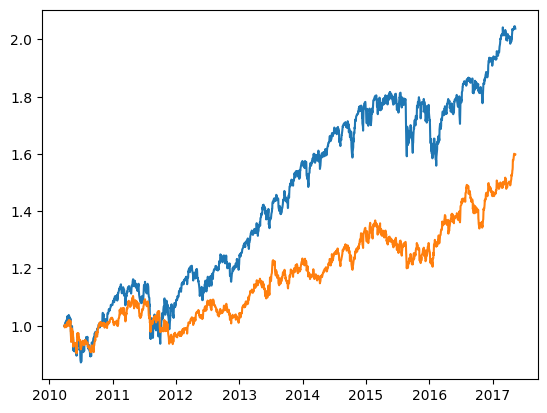

In [7]:
import pandas as pd
import yfinance as yf
df = yf.download('^GSPC',start,end)

print((df['Adj Close'].iloc[-1]-df['Adj Close'].iloc[0])/df['Adj Close'].iloc[0])
sp = df['Adj Close'].pct_change() + 1
sp.iloc[0] = 1
plt.plot(sp.cumprod())
plt.plot((1 + returns).cumprod())

In [2]:
total_return = (results.portfolio_value[-1] - results.portfolio_value[0]) / results.portfolio_value[0]

# Print the total return
print('Total return: {:.2f}%'.format(total_return * 100))

NameError: name 'results' is not defined

In [1]:
print(results)

NameError: name 'results' is not defined